In [1]:
# 1. Thêm các thư viện cần thiết
import numpy as np 
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from keras.layers import Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import time

In [2]:
# 2. load data
train_dir = "../input/cat-and-dogs/dataset/training_set/"
test_dir = "../input/cat-and-dogs/dataset/test_set"

CATEGORIES = {
    0: "Cat",
    1: "Dog"
}

img_width = 224
img_height = 224
img_channel = 3

aug_train = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True)
aug_test = ImageDataGenerator(rescale=1./255)

train_generator = aug_train.flow_from_directory(train_dir, target_size=(img_width, img_height), 
                                                     subset='training', class_mode='categorical')
val_generator = aug_train.flow_from_directory(train_dir, target_size=(img_width, img_height), 
                                                   subset='validation', class_mode='categorical')
test_generator = aug_test.flow_from_directory(test_dir, target_size=(img_width, img_height), 
                                                    class_mode='categorical')

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


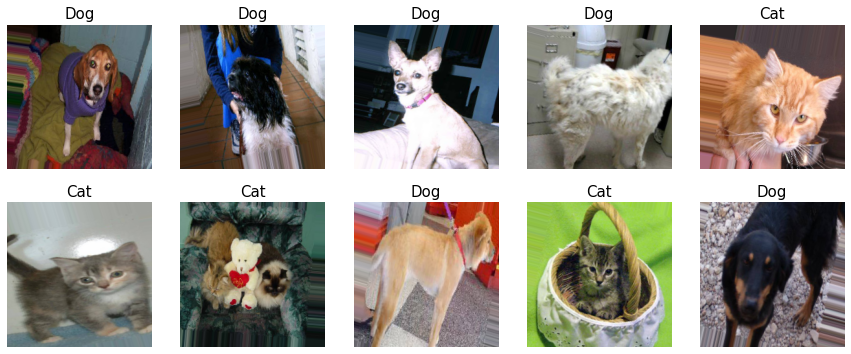

In [3]:
# 3. show image
img, label = train_generator.next()
label = np.argmax(label, axis=1)
rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    axes[i].set_title(CATEGORIES[label[i]], fontsize=15)

In [4]:
# 4. Load base_model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, img_channel))
base_model.trainable = False

2022-08-13 03:32:05.951723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 03:32:06.074177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 03:32:06.075431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 03:32:06.078442: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step


In [5]:
# 5. Build model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
# 6. train model
start_time = time.time()

numOfEpoch = 12
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2,
                                            verbose = 1,factor = 0.5,min_lr = 0.00001)
model_checkpoint = ModelCheckpoint(filepath='../input/model.h5', monitor='val_acc', 
                                   mode='max', save_best_only=True)

H =  model.fit(train_generator, epochs = numOfEpoch, validation_data = val_generator, 
               verbose=1, callbacks=[earlystop, learning_rate_reduction, model_checkpoint])

end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

2022-08-13 03:32:11.923126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2022-08-13 03:32:13.998311: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 157s 736ms/step - loss: 0.6004 - accuracy: 0.8253 - val_loss: 0.2431 - val_accuracy: 0.9025
Epoch 2/12
200/200 [==============================] - 108s 540ms/step - loss: 0.2828 - accuracy: 0.8759 - val_loss: 0.2167 - val_accuracy: 0.9075
Epoch 3/12
200/200 [==============================] - 111s 557ms/step - loss: 0.2578 - accuracy: 0.8923 - val_loss: 0.2287 - val_accuracy: 0.8950
Epoch 4/12
200/200 [==============================] - 111s 554ms/step - loss: 0.2558 - accuracy: 0.8922 - val_loss: 0.2166 - val_accuracy: 0.9062

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/12
200/200 [==============================] - 110s 552ms/step - loss: 0.2235 - accuracy: 0.9064 - val_loss: 0.1876 - val_accuracy: 0.9237
Epoch 6/12
200/200 [==============================] - 111s 557ms/step - loss: 0.2072 - accuracy: 0.9134 - val_loss: 0.1842 - val_accuracy: 0.9212
Epoch 7/12
200/200 [==============================] - 

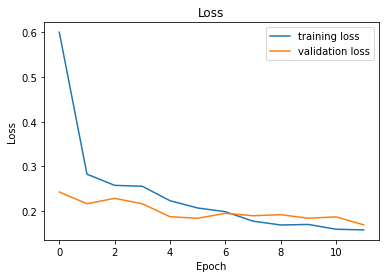

In [7]:
# 7. Vẽ đồ thị loss của traning set và validation set
plt.plot(np.arange(0, len(H.epoch)), H.history['loss'], label='training loss')
plt.plot(np.arange(0, len(H.epoch)), H.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

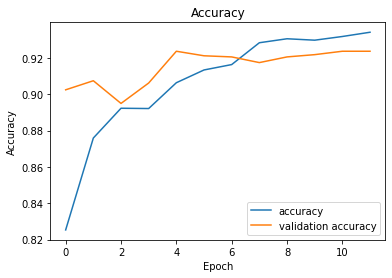

In [8]:
# 8. Vẽ đồ thị accuracy của traning set và validation set
plt.plot(np.arange(0, len(H.epoch)), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, len(H.epoch)), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [9]:
# 9. Đánh giá model với testset
start_time = time.time()
print('[loss, accuracy]: ', model.evaluate(test_generator, verbose = 1))
end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

63/63 [==============================] - 19s 295ms/step - loss: 0.1641 - accuracy: 0.9360
[loss, accuracy]:  [0.16414286196231842, 0.9359999895095825]
Running time: 18.82 (s)


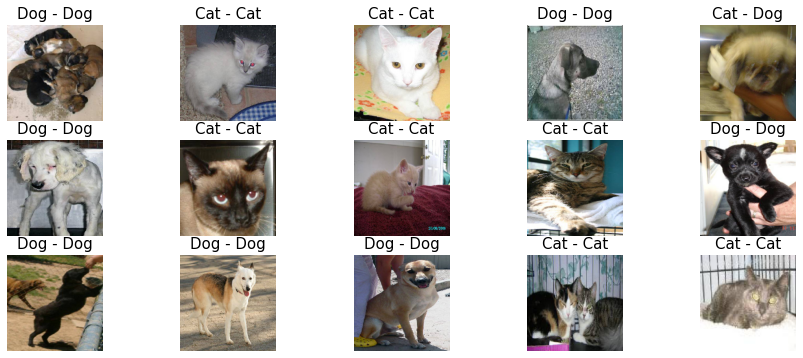

In [10]:
# 10. Predict
img, label = test_generator.next()
label = np.argmax(label, 1)
rows = 3
cols = 5

y_pred = model.predict(img[0: rows * cols])
y_pred = np.argmax(y_pred, 1)

fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    axes[i].set_title(CATEGORIES[y_pred[i]] + ' - ' + CATEGORIES[label[i]], fontsize=15)

In [11]:
# 11. Save model
model.save('Dog_Cat_Model.h5')